<a href="https://colab.research.google.com/github/Jatchen/Machine-Learning/blob/main/0221_ML_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAX 452 - Homework 4
- By Hema Sudarsan Rao
- By Vania
- By Jiateng Chen

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# Loading the required dataset
medical = pd.read_csv("/content/drive/MyDrive/ML_HW5_medical-SMALL-sample.csv")
medical.rename(columns={'ss': 'journey_id'}, inplace=True)
scrpits = pd.read_csv("/content/drive/MyDrive/ML_HW5_scripts-SMALL-sample.csv")

# Handle missing values
medical = medical.dropna(subset=['diag_list'])
scrpits = scrpits.dropna(subset=['diagnosis_code'])

<ipython-input-3-8d9f61ba5e05>:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  scrpits = pd.read_csv("/content/drive/MyDrive/ML_HW5_scripts-SMALL-sample.csv")


# Part 1: Data Preprocessing and Merging

**STEPS I TAKE:**

1. First we find the key variables in order to identify the effect. For example, ndc11 in medical table represents for Ozempic, here we use 169418113 to represent this. Diag_list in scripts represents the kinds of illness the patient may have, including diabetes (the purpose of Ozeempic), obese and hypertension. We also ignore the claim related code because it has nothing to do with our goal.
2. Second, we did not merge the dataset, because the only shared variable is journey_id, which is not unique in each table. Merging through this leads to cartesian product problems.
3. Third, our target population for this analysis is diabetes people, because other patients will not get Ozempic as a treatment method.
4. In the end, we decide to create variables for each patient and build a new dataset for future analysis. For example, we create the outcome variable as improved, through identifying whether the diabetes disappears or not. If it does disappear, we mark it as 1, else 0. We also created the treatment variable as if ndc 11 contains 169418113, we marked treatment for this patient as 1. In order to capture the confounders, we also created the is_obses variable, age, gender, claim_charged and so on.


In [4]:
# Filter out journey_ids with diagnosis_codes containing any one of ['E08', 'E09', 'E10', 'E11', 'E13'], which is diabetes.
diagnosis_codes = ['E08','E09','E10','E11','E13']
filtered_journey_ids = scrpits[scrpits['diagnosis_code'].str.contains('|'.join(diagnosis_codes))]['journey_id'].unique()

# Retain records from the scripts table that contain the relevant journey_ids, saving them in the scripts_E table
scripts_E = scrpits[scrpits['journey_id'].isin(filtered_journey_ids)]
medical_E = medical[medical['journey_id'].isin(filtered_journey_ids)]

In [5]:
# Filter out journey_ids with diagnosis_codes containing any one of ['E08', 'E09', 'E10', 'E11', 'E13'], which is diabetes.
diagnosis_codes = ['E08','E09','E10','E11','E13']
filtered_journey_ids = scrpits[scrpits['diagnosis_code'].str.contains('|'.join(diagnosis_codes))]['journey_id'].unique()

# Retain records from the scripts table that contain the relevant journey_ids, saving them in the scripts_E table
scripts_E = scrpits[scrpits['journey_id'].isin(filtered_journey_ids)]

# Based on the results from scripts_E, find the record corresponding to the last date_prescription_written for each journey_id
last_prescription = scripts_E.groupby('journey_id').apply(lambda x: x.sort_values(by='date_prescription_written').iloc[-1])

# For each journey_id, if the record does not contain any one of the diagnosis_codes ['E08', 'E09', 'E10', 'E11', 'E13'], set Outcome to 1; otherwise, set Outcome to 0
last_prescription['Outcome'] = last_prescription.apply(lambda x: 1 if not any(code in x['diagnosis_code'] for code in diagnosis_codes) else 0, axis=1)

Outcome_df_2 = last_prescription[['journey_id', 'Outcome']].reset_index(drop=True)

print(Outcome_df_2)

                            journey_id  Outcome
0     00011020325337a2a22fb26b6492196a        0
1     000611c33bf684a7fec8eb5bf8ef2c80        0
2     000f40e84695544650e491b7585bd483        0
3     00155fc1aefb64fa072f40de56c979f0        1
4     001a7777c088977b21100828fab27911        1
...                                ...      ...
1470  1fe302675dc2c9d573beb76344517684        0
1471  1fee90f7f55aee313daf3f7042256581        1
1472  1ff8fc83bf1796e9a601c6fdaaa5a3ef        1
1473  1ff8ff0a9c69c0d70e83a2061727c792        1
1474  1fff19f39322d5c25a60259f30d937a4        0

[1475 rows x 2 columns]


In [6]:
# Create treatment D: Whoever has taken Ozempic, i.e. 169418113
scrpits = scrpits.dropna(subset=['ndc11'])
scrpits['ndc11'] = scrpits['ndc11'].astype(str)
treated_journeys = scrpits[scrpits['ndc11'] == '169418113']['journey_id'].unique()

In [7]:
# Create X variables
is_diabetes = medical[medical['diag_list'].str.contains('E08|E09|E10|E11|E13')]['journey_id'].unique()
is_Obese = medical[medical['diag_list'].str.contains('E66|Z68')]['journey_id'].unique()
is_Hypertention = medical[medical['diag_list'].str.contains('I10|I15')]['journey_id'].unique()

In [8]:
## Merge the datasets and encode categorical data for use in regression model

# Add is_treatment to outcome_df
Outcome_df_2['Is_treatment'] = 0
Outcome_df_2.loc[Outcome_df_2['journey_id'].isin(treated_journeys), 'Is_treatment'] = 1

# Add is_diabetes to outcome_df
Outcome_df_2['is_diabetes'] = 0
Outcome_df_2.loc[Outcome_df_2['journey_id'].isin(is_diabetes), 'is_diabetes'] = 1

# Add is_Obese to outcome_df
Outcome_df_2['is_Obese'] = 0
Outcome_df_2.loc[Outcome_df_2['journey_id'].isin(is_Obese), 'is_Obese'] = 1

# Add is_Hypertention to outcome_df
Outcome_df_2['is_Hypertention'] = 0
Outcome_df_2.loc[Outcome_df_2['journey_id'].isin(is_Hypertention), 'is_Hypertention'] = 1

# Add age
journey_age_map = medical.set_index('journey_id')['patient_age'].to_dict()
Outcome_df_2['Age'] = Outcome_df_2['journey_id'].map(journey_age_map)

# convert 'M' to 1 and 'F' to 0
medical['patient_gender_int'] = medical['patient_gender'].map({'M': 1, 'F': 0})

# Add gender
patient_gender_map = medical.set_index('journey_id')['patient_gender_int'].to_dict()
Outcome_df_2['Gender'] = Outcome_df_2['journey_id'].map(patient_gender_map)

# Add line charge
line_charge_map = medical.set_index('journey_id')['line_charge'].to_dict()
Outcome_df_2['line_charge'] = Outcome_df_2['journey_id'].map(line_charge_map)

# Add claim charge
claim_charge_map = medical.set_index('journey_id')['claim_charge'].to_dict()
Outcome_df_2['claim_charge'] = Outcome_df_2['journey_id'].map(claim_charge_map)

# Add smart allowed
smart_allowed_map = medical.set_index('journey_id')['smart_allowed'].to_dict()
Outcome_df_2['smart_allowed'] = Outcome_df_2['journey_id'].map(smart_allowed_map)

print(Outcome_df_2)

                            journey_id  Outcome  Is_treatment  is_diabetes  \
0     00011020325337a2a22fb26b6492196a        0             0            1   
1     000611c33bf684a7fec8eb5bf8ef2c80        0             0            1   
2     000f40e84695544650e491b7585bd483        0             0            0   
3     00155fc1aefb64fa072f40de56c979f0        1             0            1   
4     001a7777c088977b21100828fab27911        1             0            1   
...                                ...      ...           ...          ...   
1470  1fe302675dc2c9d573beb76344517684        0             0            1   
1471  1fee90f7f55aee313daf3f7042256581        1             0            1   
1472  1ff8fc83bf1796e9a601c6fdaaa5a3ef        1             0            1   
1473  1ff8ff0a9c69c0d70e83a2061727c792        1             0            1   
1474  1fff19f39322d5c25a60259f30d937a4        0             0            1   

      is_Obese  is_Hypertention   Age  Gender  line_charge  cla

# Part 2: Exploratory Data Analysis (EDA)

<ipython-input-9-8876247ccc2f>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(Outcome_df_2.corr(), annot=True, cmap='coolwarm', linewidths=0.5)


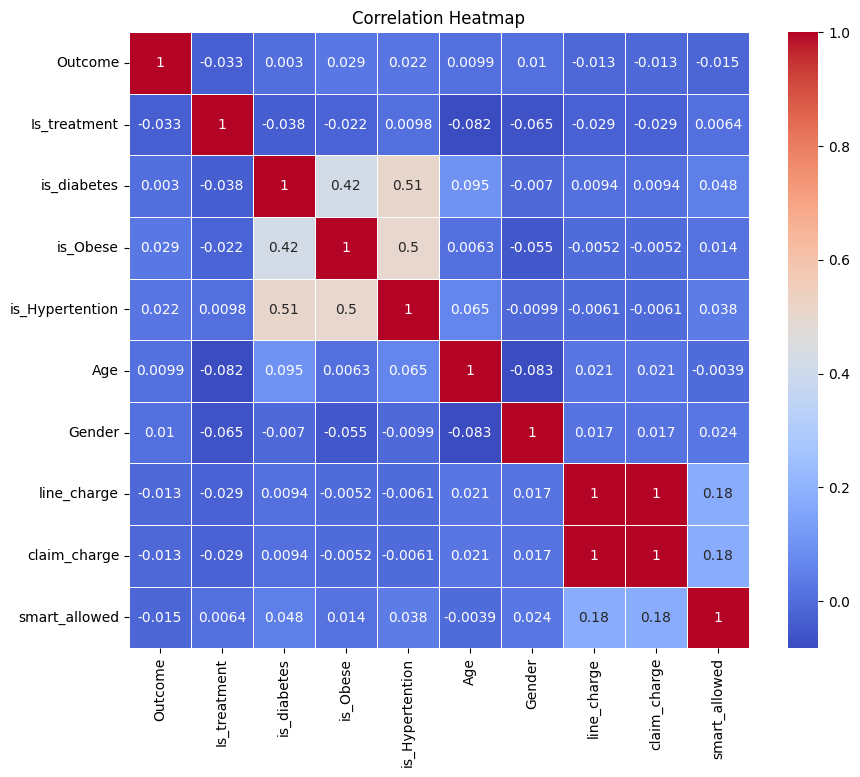

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# draw a heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(Outcome_df_2.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Insight:
we draw a heatmap first to see the relationship between different variables. We can see that three kinds of disease are correlated with each other. So we further draw the cross table to see their relationship.

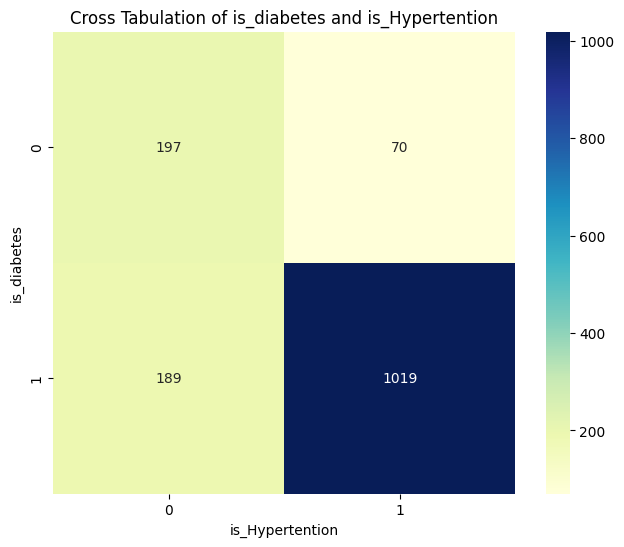

In [10]:
# create the cross tab
cross_tab = pd.crosstab(Outcome_df_2['is_diabetes'], Outcome_df_2['is_Hypertention'])

plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', cbar=True, square=True)
plt.title('Cross Tabulation of is_diabetes and is_Hypertention')
plt.xlabel('is_Hypertention')
plt.ylabel('is_diabetes')
plt.show()

Insight: we can see that for those who has hypertention, 1010 of them has diabetes too. Around 400 people has only one kind of disease. It makes sense because these two illness often happens together in real life. But we need to be careful for the endogeneity issue.

# Part 3: Causal Analysis Setup

 the potential endogeneity issues:
 1. We define the outcome variable as disappear or not, we did not specific the time, like after taking Ozempic or before. So it may happen simultaneously and affect each other.
 2. The covariates we choose may have a strong influence on the treatment variable. For example, older people are more likely to get diabetes

strategy for addressing endogeneity:
We plan to use double-lasso to address the problem.
1. first stage we analyze the relationship between treatment and covariates, we can have a idea about how covariate will affect our treatment.
2. second stage, we predict the d_hat from 1st stage, to represent the covariate's influence. Then we perform a lasso about outcome, treatment, d_hat and covariates, with only penalizing covariates. In this casee, we can understand how much the prue treatment will affect the outcome and exclude the influence from covariate.

# Part 4: Model Development: Double-Lasso / Treatment Effect Lasso

In the first stage, we use lasso regression to select relevant variables for the treatment equation and the outcome equation.

In [12]:
# Handle missing values
Outcome_df_2 = Outcome_df_2.dropna()

# Removing journey_id from the dataframe
Outcome_df_2.drop(columns = 'journey_id',inplace = True)

# Defining our X and d for first lasso regression
X = Outcome_df_2.drop(columns = ['Outcome','Is_treatment'])
d = Outcome_df_2['Is_treatment']

<ipython-input-12-d1bbe29f00f5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Outcome_df_2.drop(columns = 'journey_id',inplace = True)


In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler to X and transform X
X = scaler.fit_transform(X)

In [14]:
from sklearn.linear_model import Lasso

# Fit the lasso regression on X and d variables
lasso1 = Lasso(alpha=0.1)
lasso1.fit(X, d)

# Define dhat
dhat = lasso1.predict(X)

# Add the values of dhat back to our dataframe
Outcome_df_2['d_hat'] = dhat
Outcome_df_2.head()

,Outcome,Is_treatment,is_diabetes,is_Obese,is_Hypertention,Age,Gender,line_charge,claim_charge,smart_allowed,d_hat
0,0,0,1,1,1,75.0,1.0,2500.00,2500.00,0.00,0.093643
1,0,0,1,0,0,50.0,0.0,0.01,0.01,0.00,0.093643
2,0,0,0,0,0,50.0,0.0,150.00,150.00,0.00,0.093643
3,1,0,1,1,1,70.0,0.0,68.64,68.64,74.61,0.093643
4,1,0,1,0,1,60.0,0.0,82.00,82.00,166.99,0.093643


In [15]:
from sklearn.model_selection import train_test_split

# Prepare feature variables (X) and target variable (y)
X = Outcome_df_2.drop(columns = ['Outcome'])  # Exclude outcome to isolate features
y = Outcome_df_2['Outcome']  # Target variable

# Split dataset into training and testing sets with 20% of data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

# Remove treatment indicator and predicted treatment effect from training features
X_train_updated = X_train.drop(columns=['Is_treatment', 'd_hat'])

# Extract treatment indicator and predicted treatment effect for training set
d_train = X_train['Is_treatment']
d_hat_train = X_train['d_hat']

# Repeat the process for test data
X_test_updated = X_test.drop(columns=['Is_treatment', 'd_hat'])
d_test = X_test['Is_treatment']
d_hat_test = X_test['d_hat']

# Combine treatment indicators, predicted effects, and other features for final training set
X_train_final = pd.concat([d_train, d_hat_train, X_train_updated], axis=1)

# Repeat combination for final test set
X_test_final = pd.concat([d_test, d_hat_test, X_test_updated], axis=1)

# Display the first few rows
X_train_final.head()

,Is_treatment,d_hat,is_diabetes,is_Obese,is_Hypertention,Age,Gender,line_charge,claim_charge,smart_allowed
663,0,0.093643,1,1,1,40.0,1.0,219.0,219.0,106.45
1206,0,0.093643,1,1,1,55.0,1.0,40.0,40.0,36.25
1028,0,0.093643,1,1,1,55.0,1.0,0.0,0.0,224.67
1236,0,0.093643,1,1,1,70.0,0.0,70.0,70.0,52.17
968,1,0.093643,1,1,1,60.0,1.0,0.0,0.0,103.83


In [16]:
# Defining a function to apply penality on choosen columns variables

class SelectiveRegularizationLinearRegression:
    def __init__(self, alpha, apply_penalty, tolerance=1e-4, max_iterations=1000):
        self.alpha = alpha
        self.tolerance = tolerance
        self.apply_penalty = apply_penalty
        self.max_iterations = max_iterations
        self.w = None

    def _predicted_values(self, X, w):
        return np.matmul(X, w)

    def _rho_compute(self, y, X, w, j):
        X_k = np.delete(X, j, 1)
        w_k = np.delete(w, j)
        predict_k = self._predicted_values(X_k, w_k)
        residual = y - predict_k
        rho_j = np.sum(X[:, j] * residual)
        return rho_j

    def _z_compute(self, X):
        return np.sum(X * X, axis=0)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if not self.w:
            self.w = np.zeros(n_features)
        z = self._z_compute(X)
        for iteration in range(self.max_iterations):
            max_step = 0
            for j in range(n_features):
                rho_j = self._rho_compute(y, X, self.w, j)
                w_j_old = self.w[j]
                if j == 0:
                    self.w[j] = rho_j / z[j]
                else:
                    if self.apply_penalty[j]:
                        if rho_j < -self.alpha * n_samples:
                            self.w[j] = (rho_j + self.alpha * n_samples) / z[j]
                        elif -self.alpha * n_samples <= rho_j <= self.alpha * n_samples:
                            self.w[j] = 0.
                        elif rho_j > self.alpha * n_samples:
                            self.w[j] = (rho_j - self.alpha * n_samples) / z[j]
                    else:
                        self.w[j] = rho_j / z[j]
                max_step = max(max_step, abs(self.w[j] - w_j_old))
            if max_step < self.tolerance:
                break
        return self

    def predict(self, X):
        if self.w is None:
            raise ValueError("Model is not fitted yet!")
        return self._predicted_values(X, self.w)

In [17]:
# Convert the final training set to a NumPy array for model fitting
X = X_train_final.values

# Manually add an intercept to feature matrix for linear regression
n_samples = len(X)
X = np.hstack((np.ones((n_samples, 1)), X))

# Convert the target variable of the training set to a NumPy array
y = y_train.values

In [18]:
# Define penalty application: No penalty on the first two coefficients, apply penalty on the next 9
apply_penalty = np.array([False, False] + [True] * 9)

# Set the strength of the L1 regularization term
alpha = 0.1

# Set the maximum number of iterations for the optimization algorithm
max_iterations = 1000

# Initialize the selective regularization linear regression model with specified parameters
model = SelectiveRegularizationLinearRegression(alpha, apply_penalty, max_iterations)

# Fit the model to the training data
model.fit(X, y)

# Part 5: Model Evaluation and Interpretation

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add the intercept on test data
n_samples_test = X_test_final.shape[0]
X_test_with_intercept = np.hstack((np.ones((n_samples_test, 1)), X_test_final.values))

# Calculate prediction outcomes on test Set
y_pred = model.predict(X_test_with_intercept)

# Calculate performance metrics for model evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the values
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 0.18960028920447305
Mean Absolute Error (MAE): 0.3371941669641072
R-squared (R²): -0.02234998336255356


In [20]:
# Treatment effect is the first coefficient in model.w
treatment_effect = model.w[0]
print(f"Treatment Effect: {treatment_effect}")

Treatment Effect: 0.821917808219178


In [21]:
print(model)

**INSIGHTS:**

1. treatment effect of 0.821917808219178 shows positive effects of Ozempic on certain patients.
2. The OOS MSE of 0.18 shows our model has a low error when predicting unseen data. However, the negative R^2 suggests that our model perform worse than null model, which can be a sign of overly penalization during lasso and loss too many coefficients.
3. In this study, we are interested in the coefficient and significance level of treatment, the nagetive R^2 will not affect this.

# Part 6: Additional Insights

1. After analyzing the dataset provided and search for the process of seeing a doctor in America, we create a new input data instead of merging the dataset.
2. If I have more time, I'll try to use Propensity score matching to control the covariates.

# THE END

In [23]:
%%shell
jupyter nbconvert --to html "/content/0221_ML_HW4.ipynb"

[NbConvertApp] Converting notebook /content/0221_ML_HW4.ipynb to html
[NbConvertApp] Writing 843453 bytes to /content/0221_ML_HW4.html
